In [40]:
import sys
import os
import json
import torch
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace
from torch.utils.data import DataLoader, Subset

# Local imports
sys.path.append(os.path.abspath(os.path.join('..', 'models')))
sys.path.append(os.path.abspath(os.path.join('..', 'data', 'datasets')))
from mlp import Model as MLP
from penmanshiel import PenmanshielDataset

In [2]:
# load hyperparameters
with open("../../hyperparameters/mlp.json", "r") as f:
    hp = json.load(f)
args = SimpleNamespace(**hp)

In [23]:
# load data
df = pd.read_csv("../../data/cleaned/Cleaned_Data.csv", index_col=0, parse_dates=True)
dataset = PenmanshielDataset(
        data_file="../../data/cleaned/Cleaned_Data.csv",
        lookback_timesteps=args.lookback_timesteps,
        forecast_timesteps=args.forecast_timesteps,
    )
n = len(dataset)
n_train = int(args.train_share * n) 
n_val = int(args.val_share * n)  
n_test = n - n_train - n_val
df_test = df.iloc[n_train + n_val:]
dataset_test = Subset(dataset, range(n_train + n_val, n_train + n_val + n_test))
loader_test = DataLoader(dataset_test)
print(f"Test set size: {len(dataset_test)}")
print(f"Size of test df: {len(df_test)}")
print(f"Difference = {len(df_test) - len(dataset_test)}")
print(f"Lookback + forecast timesteps - 1 = {args.lookback_timesteps + args.forecast_timesteps - 1}")
df_test.head()

Test set size: 7882
Size of test df: 7899
Difference = 17
Lookback + forecast timesteps - 1 = 17


,Power (kW),Wind Speed (m/s),Wind Speed Forecast (m/s),Wind Direction (°),Wind Direction Forecast (°)
timestamp,,,,,
2022-11-07 03:30:00,0.531847,0.344337,0.277078,0.585234,0.614438
2022-11-07 03:40:00,0.664800,0.344337,0.277078,0.585234,0.614438
2022-11-07 03:50:00,0.709148,0.344337,0.277078,0.585234,0.614438
2022-11-07 04:00:00,0.603516,0.354545,0.289902,0.605466,0.613501
2022-11-07 04:10:00,0.557055,0.354545,0.289902,0.605466,0.613501


In [3]:
model = MLP(args)
torch.serialization.add_safe_globals([model])
model.load_state_dict(torch.load("../../models/mlp.pth", weights_only=True))
model.eval()

Model(
  (mlp): ModuleList(
    (0): MLPLayer(
      (hidden): Linear(in_features=48, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (1): MLPLayer(
      (hidden): Linear(in_features=512, out_features=512, bias=True)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (projection): Linear(in_features=512, out_features=6, bias=True)
)

In [47]:
# Compute test MSE and extract some forecasts for visualization
df_results_list = []
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.MSELoss()
model.eval()
loss_list = []
for i, (X, y) in enumerate(loader_test):
    if i < 200:
        index_window = df_test.index[i : i + args.lookback_timesteps + args.forecast_timesteps]
        index_forecast = df_test.index[i + args.lookback_timesteps : i + args.lookback_timesteps + args.forecast_timesteps]
        df_i = pd.DataFrame({
            "Actual": df_test.loc[index_window, "Power (kW)"] * 28856.585504080267,
            "Predicted": None
            },
            index=index_window)
        X = X.to(device=args.device)
        y = y.to(device=args.device)
        y_pred = model(X)
        y_pred_np = y_pred.cpu().detach().numpy()
        # concatenate y_pred with leading Nones to match the index of df_i
        y_pred_padded = np.concatenate([np.array([None]*args.lookback_timesteps), y_pred_np* 28856.585504080267], axis=None)
        df_i["Predicted"] = y_pred_padded
        df_results_list.append(df_i)
        loss = loss_fn(y_pred, y)
        loss_list.append(loss.cpu().item())

print(f"Test MSE: {sum(loss_list)/len(loss_list):.4f}")

Test MSE: 0.0327


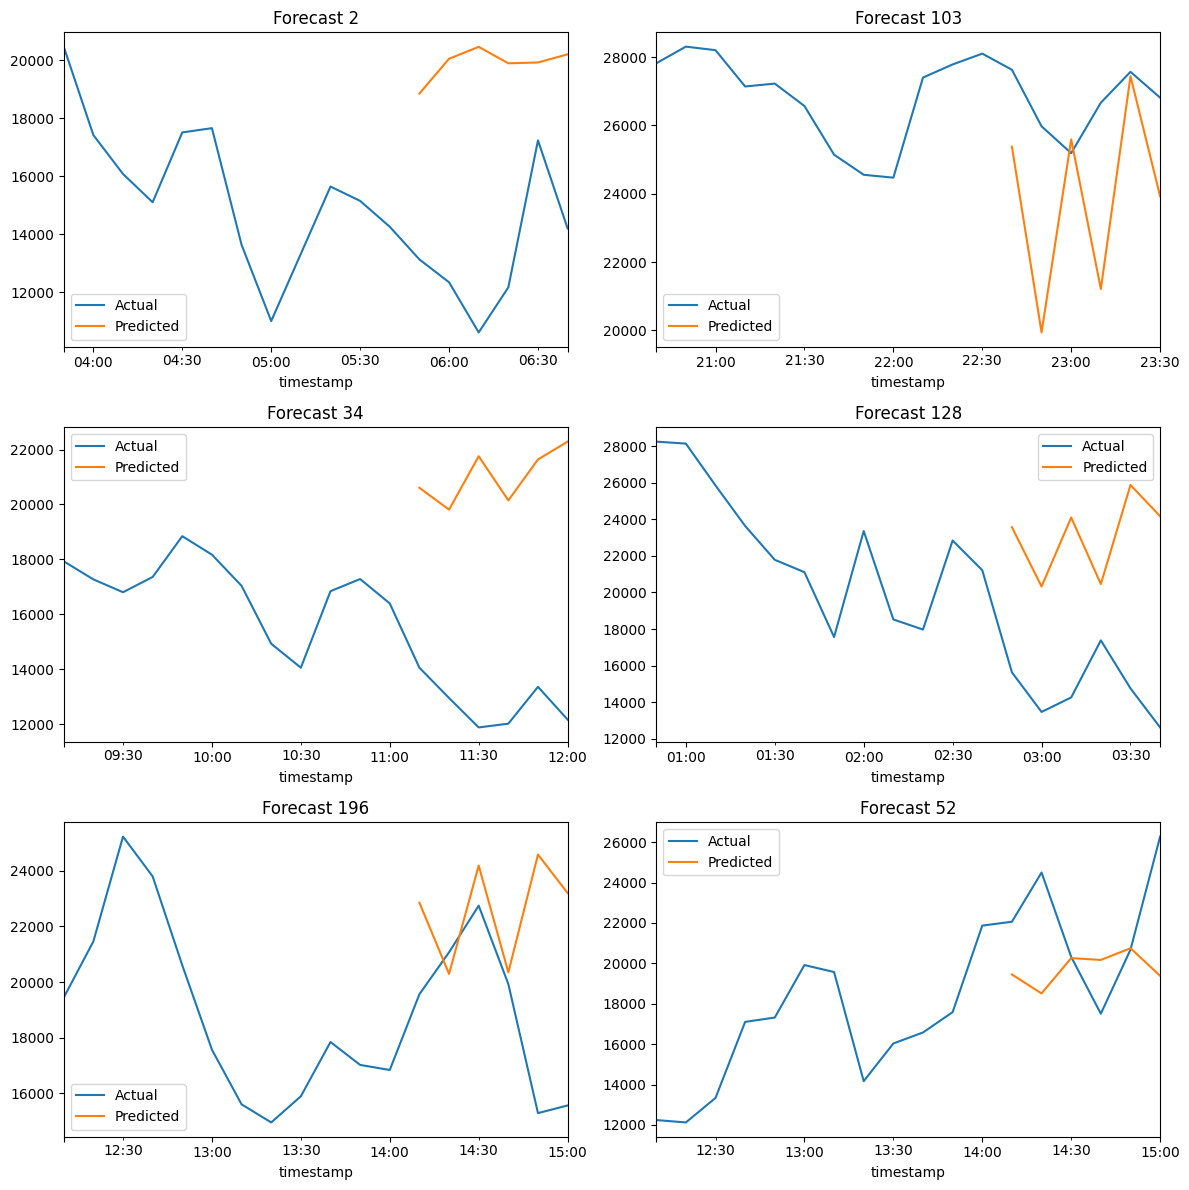

In [48]:
# draw six random integers between 0 and len(df_results_list)
n_dfs = len(df_results_list)
indices = random.sample(range(200), 6)
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, index in enumerate(indices):
    row = i // 2
    col = i % 2
    df_results_list[index].plot(ax=ax[row, col], title=f"Forecast {index}")
plt.tight_layout()
plt.show()